# Testing posterior estimators in the LFI context

In [2]:
# Importing all packages
# normalizing flows packages
import torch
from torch.utils.data import TensorDataset, DataLoader
import normflows as nf

# loforest and locart functions
from CP2LFI.loforest import ConformalLoforest, tune_loforest_LFI
from CP2LFI.scores import Scores, LambdaScore
from CP2LFI.simulations import Simulations, naive, predict_naive_quantile
from CP2LFI.posterior_models import normflow_posterior

# quantile regression
from sklearn.ensemble import HistGradientBoostingRegressor

# plotting and numpy
from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm

# package to simulate from weinberg LFI data
# weinberg data (physics)
from hypothesis.benchmark import weinberg
# mg1 data (queue theory)
from hypothesis.benchmark import mg1
# multivariate normal (toy example)
from hypothesis.benchmark import tractable

## Organizing preliminary functions and classes first:

In [3]:
# creating all used statistics scores
# waldo score 
class WaldoScore(Scores):
    def fit(self, X = None, thetas = None):
        # setting up model for normalizing flows
        if self.is_fitted:
            return self
        elif self.base_model is not None:
            self.base_model.fit(X, thetas)
        else:
            return self

    def compute(self, thetas, X, N = 10**4, one_sample = False):
        # simulating from each theta and dataset to compute waldo statistic
        i = 0
        lambdas = np.zeros(thetas.shape[0])
        
        for theta in tqdm(thetas, desc = "Computing waldo statistics using posterior model"):
            if not one_sample:
                # simulating from the model
                s = self.base_model.sample(X = X[i, :], num_samples = N)
                
                # computing E[theta|X]
                mean_theta_X = np.mean(s, axis = 0)
                var_theta_x = np.cov(s, rowvar = False)

                # computing waldo statistic
                if mean_theta_X.ndim > 1:
                    lambdas[i] = (mean_theta_X - theta).transpose() @ np.linalg.inv(var_theta_x) @ (mean_theta_X - theta)
                else:
                    lambdas[i] = (mean_theta_X - theta)**2/(var_theta_x)
                i += 1
            else:
                # simulating from the model
                s = self.base_model.sample(X = X, num_samples = N)
                
                # computing E[theta|X]
                mean_theta_X = np.mean(s, axis = 0)
                var_theta_x = np.cov(s, rowvar = False)

                # computing waldo statistic
                if mean_theta_X.ndim > 1:
                    lambdas[i] = (mean_theta_X - theta).transpose() @ np.linalg.inv(var_theta_x) @ (mean_theta_X - theta)
                else:
                    lambdas[i] = (mean_theta_X - theta)**2/(var_theta_x)
                i += 1

        return lambdas

    def predict(self, thetas_grid, X, cutoffs):
        # TODO: grid with thetas and cutoffs to generate set
        # predicting lambdas for all thetas
        lambdas = self.compute(thetas_grid, X, one_sample = True)
        idxs = list(np.where(lambdas <= cutoffs)[0])

        return thetas_grid.squeeze()[idxs]

class BFFScore(Scores):
    def fit(self, X = None, thetas = None):
        # setting up model for normalizing flows
        if self.is_fitted:
            return self
        elif self.base_model is not None:
            self.base_model.fit(X, thetas)
        else:
            return self

    def compute(self, thetas, X, one_sample = False):
        # simulating from each theta and dataset to compute waldo statistic
        # predicting posterior density for X and theta
        if not one_sample:
            return -self.base_model.predict(thetas, X)
        else:
            X_tile = np.tile(X, (thetas.shape[0], 1))
            return -self.base_model.predict(thetas, X_tile)

    def predict(self, thetas_grid, X, cutoffs):
        # TODO: grid with thetas and cutoffs to generate set
        # predicting lambdas for all thetas
        lambdas = self.compute(thetas_grid, X, one_sample = True)
        idxs = list(np.where(lambdas <= cutoffs)[0])

        return thetas_grid.squeeze()[idxs]

class E_valueScore(Scores):
    def fit(self, X = None, thetas = None):
        # setting up model for normalizing flows
        if self.is_fitted:
            return self
        elif self.base_model is not None:
            self.base_model.fit(X, thetas)
        else:
            return self
        
    def compute(self, thetas, X, N = 10**4, one_sample = False):
        # simulating from each theta and dataset to compute waldo statistic
        i = 0
        lambdas = np.zeros(thetas.shape[0])
        
        for theta in tqdm(thetas, desc = "Computing e-value statistics using posterior model"):
            if not one_sample:
                # simulating from the posterior for each X
                s = self.base_model.sample(X = X[i, :], num_samples = N)

                # computing probability for each sample
                prob_s = self.base_model.predict(s, np.tile(X[i, :], (N, 1)))

                # compute probability for theta
                prob_theta = self.base_model.predict(theta, X[i, :].reshape(1, -1))
            else:
                # simulating from the posterior for each X
                s = self.base_model.sample(X = X, num_samples = N)

                # computing probability for each sample
                prob_s = self.base_model.predict(s, np.tile(X, (N, 1)))

                # compute probability for theta
                prob_theta = self.base_model.predict(theta, X.reshape(1, -1))

            # computing e-value
            lambdas[i] = np.mean(prob_s >= prob_theta)
            i += 1

        return lambdas
    
    def predict(self, thetas_grid, X, cutoffs):
        # TODO: grid with thetas and cutoffs to generate set
        # predicting lambdas for all thetas
        lambdas = self.compute(thetas_grid, X, one_sample = True)
        idxs = list(np.where(lambdas <= cutoffs)[0])

        return thetas_grid.squeeze()[idxs]

## Starting by a visible example:

Simulating and testing for weinberg:

In [4]:
simulator = weinberg.Simulator(default_beam_energy=40.0)
prior = weinberg.Prior()

Setting $n = 100$ and $B^{'} = 20000$ for posterior modeling:

In [5]:
B_model = 20000
n = 100
torch.manual_seed(45)
# simulating thetas
thetas = prior.sample((B_model, ))
repeated_thetas = thetas.repeat_interleave(repeats = n, dim = 0)

# simulating X's
X_sample = simulator(repeated_thetas)

In [6]:
X_dim = X_sample.shape[1]
X_net = X_sample.reshape(B_model, n * X_dim)

In [8]:
X_net.shape

torch.Size([20000, 100])

Fitting normalizing flow model:

In [9]:
# reshaping thetas
thetas = thetas.reshape(-1, 1)
nflow_post = normflow_posterior(
    latent_size = thetas.shape[1],
    sample_size = X_net.shape[1], 
    n_flows = 8, 
    hidden_units = 128, 
    hidden_layers = 2,
    enable_cuda = True,
    )

nflow_post.fit(X_net.numpy(), thetas.numpy(), patience = 100, n_epochs = 2000, batch_size = 250)

Fitting normalizing flows posterior estimator:  33%|███▎      | 651/2000 [03:29<07:14,  3.10it/s]

Early stopping at epoch 651
a


normflow_posterior(latent_size=1, sample_size=100)

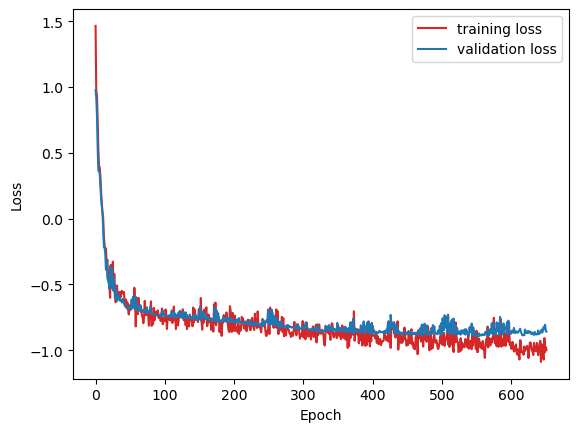

In [10]:
nflow_post.plot_history()

Simulating sample to fit confidence regions estimators:

In [12]:
# simulating to fit estimated confidence regions
B_rand = 10000
n = 100

torch.manual_seed(125)
# sampling from theta
thetas_new = prior.sample((B_rand, ))
repeated_thetas = thetas_new.repeat_interleave(repeats = n, dim = 0)
X_conf = simulator(repeated_thetas)
X_dim = X_conf.shape[1]
X_net = X_conf.reshape(B_rand, n * X_dim)

Computing all scores dataset:

In [13]:
# reshaping array
thetas_new = thetas_new.reshape(-1, 1)

# waldo score
waldo_score = WaldoScore(nflow_post, is_fitted = True)
waldo_score.fit()
sample_waldo = waldo_score.compute(thetas_new.numpy(), X = X_net.numpy(), N = 1000)

# BFF score
bff_score = BFFScore(nflow_post, is_fitted = True)
bff_score.fit()
sample_bff = bff_score.compute(thetas_new.numpy(), X = X_net.numpy())

# e-value score
e_value_score = E_valueScore(nflow_post, is_fitted = True)
e_value_score.fit()
sample_e_value = e_value_score.compute(thetas_new.numpy(), X = X_net.numpy(), N = 1000)

Computing waldo statistics using posterior model: 100%|██████████| 10000/10000 [03:03<00:00, 54.55it/s]
Computing e-value statistics using posterior model: 100%|██████████| 10000/10000 [09:38<00:00, 17.27it/s]


Fitting a fixed TRUST++ to the problem:

In [15]:
alpha, min_samples_leaf, n_estimators, K = 0.05, 300, 200, 70

# fitting TRUST++ to waldo and visualizing
loforest_waldo = ConformalLoforest(
        LambdaScore, None, alpha=alpha, is_fitted=True, split_calib=False
    )

loforest_waldo.calibrate(
    thetas_new.numpy(), 
    sample_waldo, 
    min_samples_leaf=min_samples_leaf, 
    n_estimators= n_estimators,
    K = K,
)

# fitting to BF
loforest_bf = ConformalLoforest(
        LambdaScore, None, alpha=alpha, is_fitted=True, split_calib=False
    )

loforest_bf.calibrate(
    thetas_new.numpy(), 
    sample_bff, 
    min_samples_leaf=min_samples_leaf, 
    n_estimators= n_estimators,
    K = K,
)

# fitting to e-value
loforest_e_value = ConformalLoforest(
        LambdaScore, None, alpha=alpha, is_fitted=True, split_calib=False
    )

loforest_e_value.calibrate(
    thetas_new.numpy(), 
    sample_e_value, 
    min_samples_leaf=min_samples_leaf, 
    n_estimators= n_estimators,
    K = K,
)

Computing confidence regions:

In [16]:
res_thetas = np.linspace(0.5001, 1.4999, 500).reshape(-1, 1)
# waldo cutoffs
waldo_cutoffs = loforest_waldo.compute_cutoffs(res_thetas)

# bayes factor cutoffs
bf_cutoffs = loforest_bf.compute_cutoffs(res_thetas)

# e_value cutoffs
e_value_cutoffs = loforest_e_value.compute_cutoffs(res_thetas)

Testing $X$ generated fixing $\theta = 1$:

In [17]:
# observed data with n = 5
torch.manual_seed(45)
theta = 1
X = simulator(np.repeat(theta, n))
X = X.squeeze().numpy()
X

array([-9.0912902e-01, -5.2644277e-01, -1.6158916e-01, -7.6846647e-01,
       -6.6844094e-01, -4.7640166e-01, -9.4975978e-01,  1.2970899e-01,
       -2.3482265e-01, -8.6722708e-01, -4.6376497e-01, -3.7626676e-02,
       -9.2219967e-01, -3.8411894e-01, -4.1795933e-01, -3.6648211e-01,
       -5.9312093e-01,  8.4655970e-01, -9.4386232e-01, -7.0697474e-01,
       -3.2127714e-01, -9.6454990e-01,  1.2342653e-01, -7.9238981e-01,
       -9.1915864e-01,  8.2619846e-01, -2.8910816e-01, -3.5223445e-01,
       -3.4950617e-01, -5.4576272e-01, -5.3472626e-01,  2.5259632e-01,
        7.8798610e-01, -9.3922746e-01, -6.4054769e-01, -8.2121897e-01,
       -2.9237735e-01, -3.5072705e-01, -4.0284950e-01, -4.6694434e-01,
       -5.1180953e-01, -5.0942719e-01, -9.9701577e-01, -7.2485119e-01,
       -6.4948648e-01, -5.5914307e-01,  5.6955820e-01, -8.9363265e-01,
       -8.9307576e-01, -6.0757685e-01, -6.2484628e-01, -9.7795528e-01,
       -9.7096151e-01, -9.5005333e-01, -8.8277775e-01,  8.2070035e-01,
      

Analysing distribution:

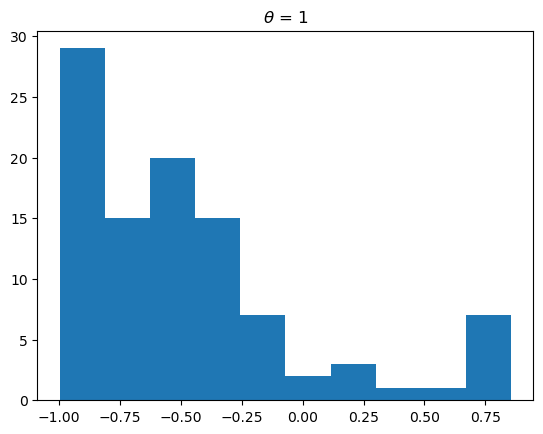

In [18]:
plt.hist(X)
plt.title(r"$\theta$ = 1")
plt.show()

Comparing to $\theta = 0.55$:

In [19]:
torch.manual_seed(45)
theta = 0.55
X_alt = simulator(np.repeat(theta, n))
X_alt = X_alt.squeeze().numpy()

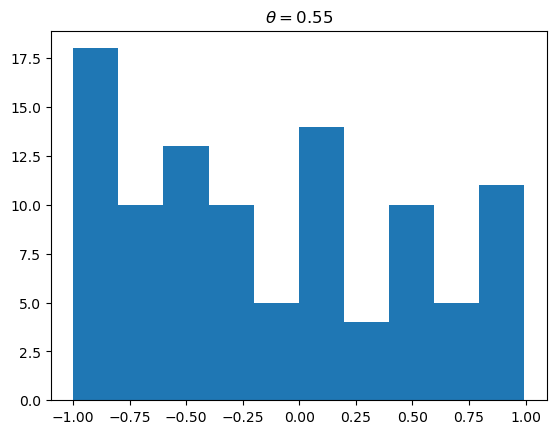

In [20]:
plt.hist(X_alt)
plt.title(r"$\theta = 0.55$")
plt.show()

In [21]:
thetas_nflow = nflow_post.sample(X, num_samples = 10000)

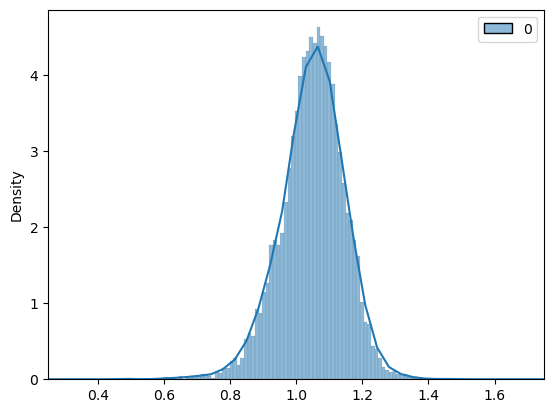

In [28]:
# posterior probability for all theta
import seaborn as sns
sns.histplot(thetas_nflow, kde = True, stat = "density")
plt.xlim(0.25, 1.75)
plt.show()

In [23]:
waldo_conf = waldo_score.predict(res_thetas, X = X, cutoffs = waldo_cutoffs)
bff_conf = bff_score.predict(res_thetas, X = X, cutoffs = bf_cutoffs)
e_value_conf = e_value_score.predict(res_thetas, X = X, cutoffs = e_value_cutoffs)

Computing waldo statistics using posterior model: 100%|██████████| 500/500 [00:12<00:00, 40.05it/s]
Computing e-value statistics using posterior model: 100%|██████████| 500/500 [00:34<00:00, 14.69it/s]


In [25]:
waldo_conf

array([0.86876373, 0.87076733, 0.87277094, 0.87477455, 0.87677816,
       0.87878176, 0.88078537, 0.88278898, 0.88479259, 0.88679619,
       0.8887998 , 0.89080341, 0.89280701, 0.89481062, 0.89681423,
       0.89881784, 0.90082144, 0.90282505, 0.90482866, 0.90683226,
       0.90883587, 0.91083948, 0.91284309, 0.91484669, 0.9168503 ,
       0.91885391, 0.92085752, 0.92286112, 0.92486473, 0.92686834,
       0.92887194, 0.93087555, 0.93287916, 0.93488277, 0.93688637,
       0.93888998, 0.94089359, 0.94289719, 0.9449008 , 0.94690441,
       0.94890802, 0.95091162, 0.95291523, 0.95491884, 0.95692244,
       0.95892605, 0.96092966, 0.96293327, 0.96493687, 0.96694048,
       0.96894409, 0.9709477 , 0.9729513 , 0.97495491, 0.97695852,
       0.97896212, 0.98096573, 0.98296934, 0.98497295, 0.98697655,
       0.98898016, 0.99098377, 0.99298737, 0.99499098, 0.99699459,
       0.9989982 , 1.0010018 , 1.00300541, 1.00500902, 1.00701263,
       1.00901623, 1.01101984, 1.01302345, 1.01502705, 1.01703

In [24]:
e_value_conf

array([0.8326988 , 0.8347024 , 0.83670601, 0.83870962, 0.84071323,
       0.84271683, 0.84472044, 0.84672405, 0.84872766, 0.85073126,
       0.85273487, 0.85473848, 0.85674208, 0.85874569, 0.8607493 ,
       0.86275291, 0.86475651, 0.86676012, 0.86876373, 0.87076733,
       0.87277094, 0.87477455, 0.87677816, 0.87878176, 0.88078537,
       0.88278898, 0.88479259, 0.88679619, 0.8887998 , 0.89080341,
       0.89280701, 0.89481062, 0.89681423, 0.89881784, 0.90082144,
       0.90282505, 0.90482866, 0.90683226, 0.90883587, 0.91083948,
       0.91284309, 0.91484669, 0.9168503 , 0.91885391, 0.92085752,
       0.92286112, 0.92486473, 0.92686834, 0.92887194, 0.93087555,
       0.93287916, 0.93488277, 0.93688637, 0.93888998, 0.94089359,
       0.94289719, 0.9449008 , 0.94690441, 0.94890802, 0.95091162,
       0.95291523, 0.95491884, 0.95692244, 0.95892605, 0.96092966,
       0.96293327, 0.96493687, 0.96694048, 0.96894409, 0.9709477 ,
       0.9729513 , 0.97495491, 0.97695852, 0.97896212, 0.98096

In [30]:
bff_conf

array([0.85473848, 0.85674208, 0.85874569, 0.8607493 , 0.86275291,
       0.86475651, 0.86676012, 0.86876373, 0.87076733, 0.87277094,
       0.87477455, 0.87677816, 0.87878176, 0.88078537, 0.88278898,
       0.88479259, 0.88679619, 0.8887998 , 0.89080341, 0.89280701,
       0.89481062, 0.89681423, 0.89881784, 0.90082144, 0.90282505,
       0.90482866, 0.90683226, 0.90883587, 0.91083948, 0.91284309,
       0.91484669, 0.9168503 , 0.91885391, 0.92085752, 0.92286112,
       0.92486473, 0.92686834, 0.92887194, 0.93087555, 0.93287916,
       0.93488277, 0.93688637, 0.93888998, 0.94089359, 0.94289719,
       0.9449008 , 0.94690441, 0.94890802, 0.95091162, 0.95291523,
       0.95491884, 0.95692244, 0.95892605, 0.96092966, 0.96293327,
       0.96493687, 0.96694048, 0.96894409, 0.9709477 , 0.9729513 ,
       0.97495491, 0.97695852, 0.97896212, 0.98096573, 0.98296934,
       0.98497295, 0.98697655, 0.98898016, 0.99098377, 0.99298737,
       0.99499098, 0.99699459, 0.9989982 , 1.0010018 , 1.00300

Plotting all confidence intervals:

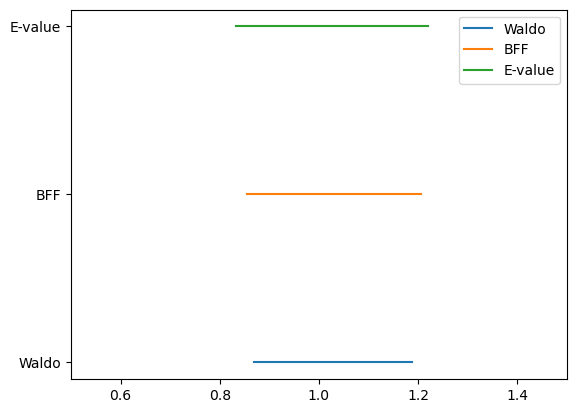

In [49]:
x_1 = np.repeat(np.array(["Waldo"]),waldo_conf.shape[0])
x_2 = np.repeat(np.array(["BFF"]),bff_conf.shape[0])
x_3 = np.repeat(np.array(["E-value"]),e_value_conf.shape[0])
plt.errorbar(waldo_conf, x_1, label = "Waldo")
plt.errorbar(bff_conf, x_2, label = "BFF")
plt.errorbar(e_value_conf, x_3, label = "E-value")
plt.xlim(0.5, 1.5)
plt.legend()
plt.show()